In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-c7eq2_dj
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-c7eq2_dj
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=7aadc940dc99713d5e170c4c1b2f5f3d4a980e2a4169b3184ba8995252a3e8e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-1u_nwrrq/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [2]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]
#List of subjects

In [4]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [5]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/kaggle/input/deap-dataset/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])


                meta.append([np.array(meta_data), np.array(labels)])    
                start = start + step_size
                
        meta = np.array(meta, dtype = object)
        np.save('s' + sub, meta, allow_pickle=True, fix_imports=True)

In [6]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [7]:
data = []
label = []

for subjects in subjectList:

    with open('/kaggle/working/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (624640, 70) (624640,)


In [8]:
with open('/kaggle/working/data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('/kaggle/working/label.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=42)

In [10]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [11]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [12]:
np.save('x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [13]:
with open('/kaggle/working/x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

In [15]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [16]:
x_train.shape

(374784, 70, 1)

In [17]:
batch_size = 256
num_classes = 4
epochs = 200
input_shape=(x_train.shape[1], 1)

In [18]:
print(input_shape)

(70, 1)


In [19]:
import tensorflow as tf

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Using GPU:", tf.test.is_gpu_available())

Num GPUs Available:  1
Using GPU: True


In [21]:
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import LSTM

In [22]:

model = Sequential()

model.add(Bidirectional(LSTM(164, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.6))

model.add(LSTM(units = 256, return_sequences = True))  
model.add(Dropout(0.6))

model.add(LSTM(units = 82, return_sequences = True))  
model.add(Dropout(0.6))

model.add(LSTM(units = 82, return_sequences = True))  
model.add(Dropout(0.4))

model.add(LSTM(units = 42))
model.add(Dropout(0.4))

model.add(Dense(units = 21))
model.add(Activation('relu'))

model.add(Dense(units = num_classes))
model.add(Activation('softmax'))
model.summary()
 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 70, 328)        │       217,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70, 328)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 70, 256)        │       599,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 70, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 70, 82)         │       111,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 70, 82)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 70, 82)         │        54,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 70, 82)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 42)             │        21,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,135 (3.83 MB)

 Trainable params: 1,004,135 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 108s 70ms/step - accuracy: 0.3718 - loss: 1.3132 - val_accuracy: 0.4381 - val_loss: 1.2163
Epoch 2/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 0.4374 - loss: 1.2189 - val_accuracy: 0.4627 - val_loss: 1.1823
Epoch 3/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 103s 70ms/step - accuracy: 0.4678 - loss: 1.1724 - val_accuracy: 0.4949 - val_loss: 1.1219
Epoch 4/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 0.4927 - loss: 1.1305 - val_accuracy: 0.5202 - val_loss: 1.0777
Epoch 5/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 0.5123 - loss: 1.0926 - val_accuracy: 0.5371 - val_loss: 1.0461
Epoch 6/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 69ms/step - accuracy: 0.5340 - loss: 1.0592 - val_accuracy: 0.5540 - val_loss: 1.0118
Epoch 7/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 0.5510 - loss: 1.0277 - val_accuracy: 0.5719 - val_loss: 0.9841
Epoch 8/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - ac

In [33]:
score = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

11712/11712 ━━━━━━━━━━━━━━━━━━━━ 152s 13ms/step - accuracy: 0.9510 - loss: 0.1653
Train loss: 0.16664506494998932
Train accuracy: 0.9503821134567261


In [34]:
score = model.evaluate(x_val, y_val, verbose=1)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.8718 - loss: 0.3779
Val loss: 0.3791460692882538
Val accuracy: 0.8709816932678223


In [35]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.8708 - loss: 0.3831
Test loss: 0.3810727894306183
Test accuracy: 0.8710057139396667


In [36]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


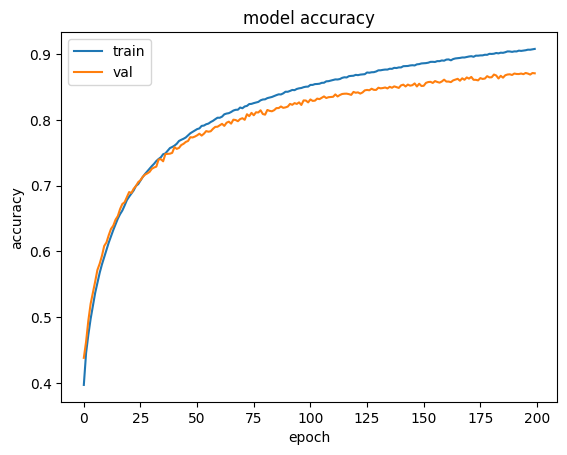

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

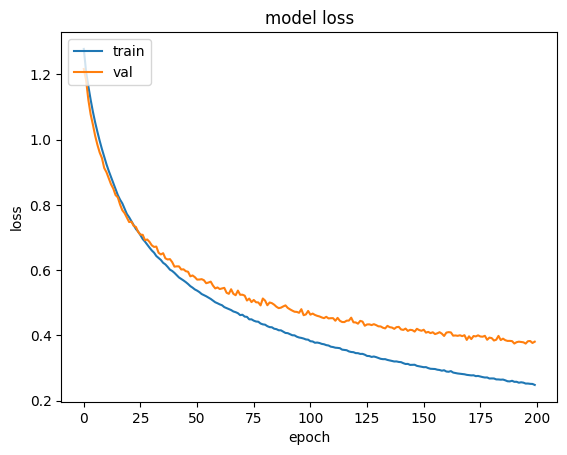

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sns

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step


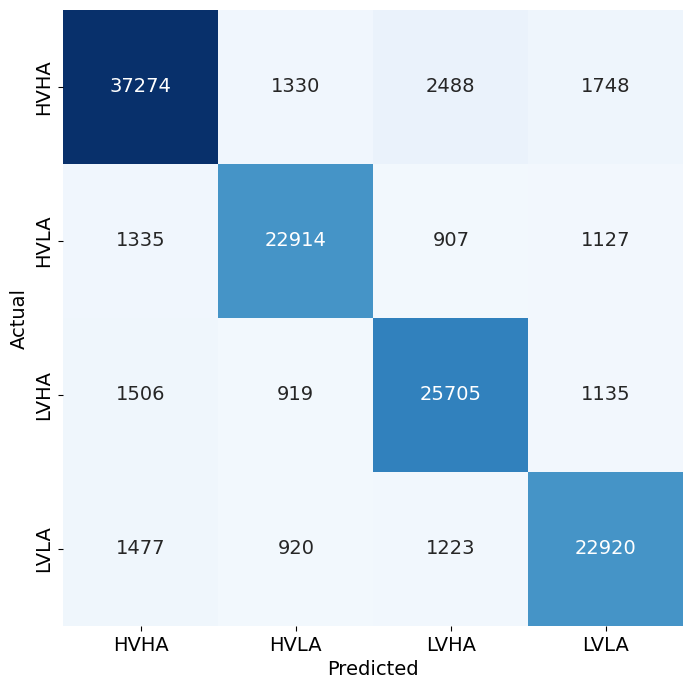

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     42840
           1       0.88      0.87      0.88     26283
           2       0.85      0.88      0.86     29265
           3       0.85      0.86      0.86     26540

    accuracy                           0.87    124928
   macro avg       0.87      0.87      0.87    124928
weighted avg       0.87      0.87      0.87    124928



In [40]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)